In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 15)
titanic_df=pd.read_csv('titanic3.csv')

from sklearn.preprocessing import LabelEncoder
# Null 처리 함수
def fillna(df):
    df['age'].fillna(df['age'].mean(), inplace=True)
    df['cabin'].fillna('N', inplace=True)
    df['fare'].fillna(df['fare'].mean(), inplace=True)
    df['embarked'].fillna('N', inplace=True)
    return df

def drop_features(df):
    df.drop(['home.dest','boat','body','name','ticket'], axis=1, inplace=True)
    return df

def format_features(df):
    df['cabin'] = df['cabin'].str[:1]
    features = ['cabin','sex','embarked']
    for feature in features:
        le = LabelEncoder()
        df[feature] = le.fit_transform(df[feature])
    return df

def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

t_df = transform_features(titanic_df)
t_df.to_pickle('t_df.pkl')
display(t_df.head())
display(t_df.columns.values)

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# 독립변수, 종속변수 분리
X = t_df[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'cabin', 'embarked']]
y = t_df['survived']

# 독립변수 정규화(평균 0, 분산1인 표준정규분포)
X = preprocessing.StandardScaler().fit(X).transform(X) # StandardScaler : 표준정규분포

# 학습용 데이터와 평가용 데이터를 8:2로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

print(X_train.shape) # (1047, 8) 80% 데이터 갯수
print(X_test.shape) # (262, 8) 20% 데이터 갯수
print()
print(X.mean())  # -4.885320566723378e-17 (0.0 이 17개 있어서 거의 0이라고 보면 된다.)-> 평균 = 0
print(X.std())   # 1.0 표준편차 
print(type(y_test)) # <class 'pandas.core.series.Series'>

# Decision Tree
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier()  # 객체 생성
dt_model.fit(X_train, y_train)       # 트레이닝 데이터로 학습
dt_pred = dt_model.predict(X_test)   # 검증용 데이터로 예측

print(dt_pred[0:10])        # 예측값과
print(y_test.values[0:10]) # 실제 y 값을 대조하며 검증

accuracy = accuracy_score(y_test, dt_pred)
print('dt 예측 정확도:',accuracy) # 예측 정확도가 좋지 못하면 재개발 해야함
# 분석용 데이터셋을 잘 만들어서, 중요한 변수들을 뽑아내야 함.

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked
0,1,1,0,29.00,0,0,211.3375,1,3
1,1,1,1,0.92,1,2,151.5500,2,3
2,1,0,0,2.00,1,2,151.5500,2,3
3,1,0,1,30.00,1,2,151.5500,2,3
4,1,0,0,25.00,1,2,151.5500,2,3


array(['pclass', 'survived', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'cabin', 'embarked'], dtype=object)

(1047, 8)
(262, 8)

-4.885320566723378e-17
1.0
<class 'pandas.core.series.Series'>
[0 1 0 0 0 0 0 1 0 0]
[1 0 0 1 0 0 0 1 1 0]
dt 예측 정확도: 0.7519083969465649


In [2]:
# Random Forest (투표를 해가며 결정해가는 방법)
from sklearn.ensemble import RandomForestClassifier #(분류기)

rf_model = RandomForestClassifier() # 객체 생성
rf_model.fit(X_train, y_train)      # 학습을 시킨다. (트레이닝 데이터를 이용)
rf_pred = rf_model.predict(X_test)  # 학습시킨 모델을 통해 예측한다. (검증용 데이터로)

rf_accuracy = accuracy_score(y_test, rf_pred) # 예측한 것과 실제 y값으로 비교해서 예측 정확도를 구한다.
print('rf 예측 정확도:', rf_accuracy)         # 예측 정확도 출력

rf 예측 정확도: 0.767175572519084


In [3]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()           # 객체 생성
lr_model.fit(X_train, y_train)            # 생성된 객체에 학습
lr_pred = lr_model.predict(X_test)        # 학습된 모델을 통해 예측

lr_accuracy = accuracy_score(y_test, lr_pred) # 예측한 것과 실제 y값으로 비교해서 예측 정확도를 구한다.
print('lr 예측 정확도:', lr_accuracy)         # 예측 정확도 출력

lr 예측 정확도: 0.7748091603053435


In [4]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

k_model = KNeighborsClassifier(n_neighbors=5)   # 최근접 이웃이 5개인 것을 의미한다.
k_model.fit(X_train, y_train)
k_pred = k_model.predict(X_test)

k_accuracy = accuracy_score(y_test, k_pred)
print('k 예측 정확도:', k_accuracy)

k 예측 정확도: 0.7709923664122137


In [5]:
# SVM
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.metrics import classification_report
from sklearn import svm
# 벡터 공간으로 매핑하는 함수를 커널이라고 함
# kernal = 'rbf' 옵션으로 RBF(Radial Basis Function) 함수를 적용
svm_model = svm.SVC(kernel='rbf', random_state=0) # random_state=0 으로 정해서 예측치 변동이 생기지 않게 한다.
# kernel :  구분하는 선을 기준으로 선과 데이터의 거리가 margin이다. 
# 하지만, 하나의 선으로 분류할 수 있는 경우는 거의 없기 때문에 1차원을 2차원으로 만들고, 2차원을 3차원으로 만든다.
# 선을 차원으로 바꿔주는 것이 kernel.
svm_model.fit(X_train, y_train)
s_pred = svm_model.predict(X_test)

s_accuracy = accuracy_score(y_test, s_pred)
print('s 예측 정확도 :', s_accuracy)

s 예측 정확도 : 0.8015267175572519


### load_breat_cancer 데이터 세트를 불러와서 다음 사항을 수행하세요.
 - from sklearn.datasets import load_breast_cancer
 - cancer = load_breast_cancer()
   - 데이터 세트의 구성 요소를 파악하고 feature의 개수를 구하세요.
   - cancer.data를 데이터 프레임으로 변환
   - 정규화 수행
   - 학습용 데이터와 검증용 데이터를 7:3의 비율로 구분
   - Decision Tree, Logistic Regression, Random Forest 기법을 활용하여 분류예측을 각각 수행

## 나의 풀이

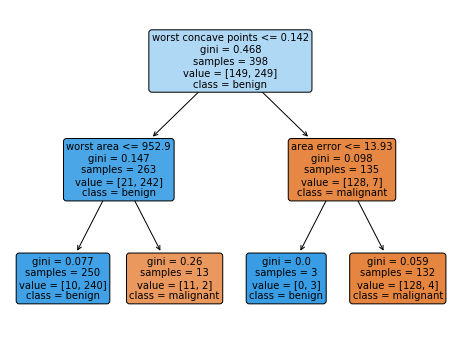

Decision Tree 예측 정확도: 0.9298245614035088


In [6]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt
%matplotlib inline

cancer = load_breast_cancer()
cancer.keys() # ['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']

X = preprocessing.StandardScaler().fit(X).transform(X) # StandardScaler : 표준정규분포

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.3, random_state=0)

dt_clf = DecisionTreeClassifier(random_state=0)
dt_clf = DecisionTreeClassifier(criterion='gini', max_depth=2, random_state=0)

dt_clf.fit(X_train, y_train)

y_hat = dt_clf.predict(X_test)

plt.figure(figsize=(8,6))
tree.plot_tree(dt_clf, filled=True,                      # 그림을 그린다.
              feature_names=cancer.feature_names,       # iris_data가 가지고 있는 데이터를 입력한다. 
              class_names=cancer.target_names,          # iris_data가 가지고 있는 데이터를 입력한다. 
              rounded=True, fontsize=10)               # 사각형의 모서리 라운드처리, 글자 사이즈
plt.show()
plt.close()

dt_model = DecisionTreeClassifier()  # 객체 생성
dt_model.fit(X_train, y_train)       # 트레이닝 데이터로 학습
dt_pred = dt_model.predict(X_test)   # 검증용 데이터로 예측

accuracy = accuracy_score(y_test, dt_pred)
print('Decision Tree 예측 정확도:',accuracy)

In [7]:
df_cancer=pd.DataFrame(cancer.data , columns=cancer.feature_names )
# cancer.data 는 우리가 아는 데이터가 배열로 들어있고
# columns=cancer.feature_names의 feature는 독립변수들(데이터들의 컬럼들)
# 불러온 데이터는 'key : 배열' 형태로 들어있고, 이것을 dataframe으로 변경해주었다.
print('feature 개수 :',len(cancer.feature_names))
display(df_cancer.head(3))
display(df_cancer.shape)
# display(cancer.target)
display(pd.Series(cancer.target).value_counts()) # 시리즈형태만 밸류카운츠 가능
display(cancer.target_names)

feature 개수 : 30


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,...,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,...,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,...,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,...,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


(569, 30)

1    357
0    212
dtype: int64

array(['malignant', 'benign'], dtype='<U9')

In [8]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

lr_model = LogisticRegression()           
lr_model.fit(X_train, y_train)            
lr_pred = lr_model.predict(X_test)        

lr_accuracy = accuracy_score(y_test, lr_pred)
print('lr 예측 정확도:', lr_accuracy)

lr 예측 정확도: 0.9532163742690059


In [9]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)     
rf_pred = rf_model.predict(X_test) 

rf_accuracy = accuracy_score(y_test, rf_pred)
print('rf 예측 정확도:', rf_accuracy)        

rf 예측 정확도: 0.9590643274853801


## 선생님 풀이

In [10]:
# 정규 분포 형태의 표준 스케일링 적용 후 train, test set 분리
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# minmaxScaler 정규화(개별값/ 최대값)
# standardscaler()로 평균이0, 분산1로 데이터 분포도 변환
scaler = StandardScaler() # 객체 생성
data_scaled = scaler.fit_transform(cancer.data) # 객체를 이용해서 fit_transform() 해준다.(정규화 작업)

X_train, X_test, y_train, y_test = train_test_split(data_scaled, cancer.target, test_size=0.3, random_state=0)

In [11]:
# DecisionTreeClassifier 를 이용해 학습 및 예측 수행
import warnings
from sklearn.tree import DecisionTreeClassifier

df_clf = DecisionTreeClassifier()
df_clf.fit(X_train,y_train)
df_preds = df_clf.predict(X_test)

# 모형 성능 평가
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, df_preds)
print('DT 예측치:',accuracy)

DT 예측치: 0.9122807017543859


In [12]:
# 로지스틱 회귀를 이용해 학습 및 예측 수행
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(random_state=0)
lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)

# 모형 성능 평가
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, lr_preds)
print('LR 예측치:',accuracy)

LR 예측치: 0.9766081871345029


In [13]:
# 랜덤 포레스트를 이용해 학습 및 예측 수행
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=10)
rf_clf.fit(X_train, y_train)
rf_preds = rf_clf.predict(X_test)

# 모형 성능 평가
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, rf_preds)
print('RF 예측치:',accuracy)

RF 예측치: 0.9649122807017544


### 교차 검증
 - KFold : K개의 데이터 폴드를 만들어서 K번 만큼 학습과 검증을 반복 수행(폴드 세트 설정, for 루프 반복 데이터 인덱스 추출, 반복 학습 수행 및 예측 성능 반환)
 - Stratified KFold : 불균형한 분포도를 가진 레이블 데이터 집합을 위한 방식(KFold 로는 부족한 경우)
    - K폴드의 경우 레이블 데이터 집합이 원본 데이터 집합의 레이블 분포를 제대로 분배 못하여 문제가 발생되는데 이 문제를 해결하기 위하여 사용
 - cross_val_scores : KFold의 일련의 과정을 한꺼번에 수행해주는 API(KFold의 절차가 복잡하기에 이 방법을 적용)
    - 분류 모델의 경우 cvs는 내부적으로 Stratified KFold 방식으로 레이블 값의 분포에 따라 학습/테스트 세트를 분할
    
 - K = 5면 5행 5열의 배열을 만든다.( k=3 이면 3행으로 만든다)
   - 첫 번째 폴드에서는 (1,1), 두 번째 폴드에서는 (2,2), (3,3) 이런식으로 계속 해서 성능을 검증해나간다. 이것을 교차검증(cross validation)이라 함

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 독립변수, 종속변수 분리
t_df = pd.read_pickle('t_df.pkl')

y_df = t_df.survived
X_df = t_df.drop('survived', axis=1)

# 학습용 평가용 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=11)

# 분류기 객체 생성
dt_clf = DecisionTreeClassifier(random_state=11)
# rf_clf = RandomForestClassifier(random_state=11)
# lr_clf = LogisticRegression(random_state=11)

from sklearn.model_selection import KFold

# KFold 교차 검증 수행()
# K개의 데이터 폴드 세트를 만들어서 K번 만큼 각 폴드 세트에
# 학습과 검증 평가를 반복, K가 5이면 5번 평가를 평균한 결과로 예측 성능 검증
# 예측 성능 평가
def exec_kfold(clf, folds=5):      # clf는 클래시파이어, folds는 k의 개수
    kfold = KFold(n_splits=folds)  # n_splits = folds
    scores = []                    # 만들어서 저장하는 공간( foltset 설정하는 단계 )
    
    for iter_count, (train_index, test_index) \
    in enumerate(kfold.split(X_df)):            # enumerate 해서 독립변수 쪽의 5개를 하나씩 작업해준다.
        X_train, X_test = X_df.values[train_index], X_df.values[test_index]
        y_train, y_test = y_df.values[train_index], y_df.values[test_index]
        
        clf.fit(X_train, y_train)                    # 반복학습 ( 이 작업들을 각 fold마다 진행 )
        predictions = clf.predict(X_test)            # 예측값 삽입 
        accuracy = accuracy_score(y_test, predictions) # 각 폴드마다 한 것을 append 해준다.
        scores.append(accuracy)                      # 5개에 대한 정확도를 출력
        print('교차 검증 {0}정확도: {1:.4f}'.format(iter_count, accuracy))
        # print('검증 세트 인덱스: {1}'.format(iter_count, test_index))
        
    mean_score = np.mean(scores)                   # mean_score로 평균을 구해준다.(5개 결과를 저장한 scores를 호출하여)
    print('평균 정확도: {0: .4f}'.format(mean_score))
        
exec_kfold(dt_clf, folds=5)       # 5로 변경하면 5개가 출력된다.

교차 검증 0정확도: 0.7099
교차 검증 1정확도: 0.7901
교차 검증 2정확도: 0.7252
교차 검증 3정확도: 0.7214
교차 검증 4정확도: 0.7663
평균 정확도:  0.7426


In [15]:
# cross_val_scores
# KFold의 일련의 과정을 한꺼번에 수행해주는 API

from sklearn.model_selection import cross_val_score

scores = cross_val_score(dt_clf, X_df, y_df, cv=10)        # cv=5는 교차검증을 얼마나 할 것인가, 숫자를 올리면 KFold와 비슷해진다.
for iter_count, accuracy in enumerate(scores):
    print('교차 검증 {0} 정확도: {1:.4f}'.format(iter_count, accuracy))
    
print('평균 정확도:{0:.4f}'.format(np.mean(scores)))

교차 검증 0 정확도: 0.5802
교차 검증 1 정확도: 0.7710
교차 검증 2 정확도: 0.8168
교차 검증 3 정확도: 0.7481
교차 검증 4 정확도: 0.7405
교차 검증 5 정확도: 0.7328
교차 검증 6 정확도: 0.6565
교차 검증 7 정확도: 0.5954
교차 검증 8 정확도: 0.6489
교차 검증 9 정확도: 0.7308
평균 정확도:0.7021


In [16]:
t_df = pd.read_pickle('t_df.pkl')

y_df = t_df.survived
X_df = t_df.drop('survived', axis=1)

# 학습용 평가용 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=11)

# 분류기 객체 생성
dt_clf = DecisionTreeClassifier()

# GridSearchCV : 파라미터를 통해 성능을 튜닝. (타이타닉 생존률을 해결하기 위해 필요한 작업)
# 교차 검증을 기반으로 하이퍼 파라미터의 최적 값을 찾게 해줌
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

parameters = {'max_depth':[2,3,5,10], 'min_samples_split':[2,3,5], 'min_samples_leaf':[1,5,8]}
# max_depth, min_samples_split, min_samples_leaf 들을 각각 [2,3,5,10], [2,3,5], [1,5,8] 씩 주고 여러번 돌려보게 한다.

grid_dclf = GridSearchCV(dt_clf, param_grid=parameters, scoring='accuracy', cv=5, refit=True) 
# refit=True는 최적으로 된 하이퍼 파라미터를 반영하겠다는 의미
display(grid_dclf)
grid_dclf.fit(X_train, y_train) # 학습을 시킨다.

print('GridSearchCV 최적 하이퍼 파라미터:', grid_dclf.best_params_) # 가장 최적인 경우를 보여준다.
#{'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}
print('GridSearchCV 최고 정확도:', grid_dclf.best_score_) # 0.8022738664843928

best_dclf = grid_dclf.best_estimator_
display(best_dclf)
dpredictions = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test, dpredictions)
print('Dicision Tree GSCV 예측 정확도 : ', accuracy) # GSCV 예측 정확도 :  0.7824427480916031

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [2, 3, 5, 10],
                         

GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}
GridSearchCV 최고 정확도: 0.8022738664843928


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Dicision Tree GSCV 예측 정확도 :  0.7824427480916031


## Q. Titanic 생존자 예측 모델 성능을 개선하고자 아래와 같이 교차 검증 및 하이퍼 파라미터 튜닝을 수행하세요.
 - KFold 교차검증(랜덤포레스트 적용)
 - cross_val_score를 활용한 교차 검증(랜덤 포레스트 적용)
 - GridSearchCV를 활용한 교차 검증과 최적 하이퍼파라미터 수행하고 성능을 평가
   - RandomForestClassifier의 최적 하이퍼 파라미터를 찾고 예측 성능 측정 parameters = {'n_estimators':[50,100,200],'max_depth':[2,3,5],'min_samples_leaf':[1,5,8]}
   - LogisticRegression의 최적 하이퍼 파라미터를 찾고 예측 성능 측정 parameters = {'penalty':['l2','l1'],'C':[0.01,0.1,1,1,5,10]}
 
#### RF 파라미터
 - n_estimators : (나무의 개수)랜덤 포레스트에서 결정 트리의 개수를 지정. 디폴트는 10개
    - 많이 설정할 수록 좋은 성능을 기대할 수  있지만 학습 수행시간이 오래 걸림
 - max_features : 결정 트리에 사용된 max_features 파라미터와 같음. sqrt(전체 피처 개수)만큼 참조. 피터가 16개라면 분할 위해 4개 참조
 
#### LR 파라미터
    - (과재적합을 피하기 위해 회귀계수를 조정해야하는데, 조정하는 방식을 말한다.)
 - L1 : 불필요한 회귀계수를 급격하게 감소시켜 0으로 만들고 제거
 - L2 : 회귀 계수의 크기를 감소시킴
 - C : 규제 강도를 조절하는 alpha 값의 역수. 즉 C값이 작을 수록 규제 강도가 큼

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 독립변수, 종속변수 분리
t_df = pd.read_pickle('t_df.pkl')

y_df = t_df.survived
X_df = t_df.drop('survived', axis=1)

# 학습용 평가용 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=11)

# 분류기 객체 생성
# dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
# lr_clf = LogisticRegression(random_state=11)

from sklearn.model_selection import KFold

# KFold 교차 검증 수행()
# K개의 데이터 폴드 세트를 만들어서 K번 만큼 각 폴드 세트에
# 학습과 검증 평가를 반복, K가 5이면 5번 평가를 평균한 결과로 예측 성능 검증
# 예측 성능 평가
def exec_kfold(clf, folds=5):      # clf는 클래시파이어, folds는 k의 개수
    kfold = KFold(n_splits=folds)  # n_splits = folds
    scores = []                    # 만들어서 저장하는 공간( foltset 설정하는 단계 )
    
    for iter_count, (train_index, test_index) \
    in enumerate(kfold.split(X_df)):            # enumerate 해서 독립변수 쪽의 5개를 하나씩 작업해준다.
        X_train, X_test = X_df.values[train_index], X_df.values[test_index]
        y_train, y_test = y_df.values[train_index], y_df.values[test_index]
        
        clf.fit(X_train, y_train)                    # 반복학습 ( 이 작업들을 각 fold마다 진행 )
        predictions = clf.predict(X_test)            # 예측값 삽입 
        accuracy = accuracy_score(y_test, predictions) # 각 폴드마다 한 것을 append 해준다.
        scores.append(accuracy)                      # 5개에 대한 정확도를 출력
        print('교차 검증 {0}정확도: {1:.4f}'.format(iter_count, accuracy))
        # print('검증 세트 인덱스: {1}'.format(iter_count, test_index))
        
    mean_score = np.mean(scores)                   # mean_score로 평균을 구해준다.(5개 결과를 저장한 scores를 호출하여)
    print('평균 정확도: {0: .4f}'.format(mean_score))
        
exec_kfold(rf_clf, folds=5)       # 5로 변경하면 5개가 출력된다.

교차 검증 0정확도: 0.7710
교차 검증 1정확도: 0.8473
교차 검증 2정확도: 0.7405
교차 검증 3정확도: 0.6947
교차 검증 4정확도: 0.7816
평균 정확도:  0.7670


In [18]:
# cross_val_scores
# KFold의 일련의 과정을 한꺼번에 수행해주는 API

from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf_clf, X_df, y_df, cv=10)        # cv=5는 교차검증을 얼마나 할 것인가, 숫자를 올리면 KFold와 비슷해진다.
for iter_count, accuracy in enumerate(scores):
    print('교차 검증 {0} 정확도: {1:.4f}'.format(iter_count, accuracy))
    
print('평균 정확도:{0:.4f}'.format(np.mean(scores)))

교차 검증 0 정확도: 0.5573
교차 검증 1 정확도: 0.8397
교차 검증 2 정확도: 0.8092
교차 검증 3 정확도: 0.7939
교차 검증 4 정확도: 0.7710
교차 검증 5 정확도: 0.8397
교차 검증 6 정확도: 0.7099
교차 검증 7 정확도: 0.6183
교차 검증 8 정확도: 0.6565
교차 검증 9 정확도: 0.6923
평균 정확도:0.7288


In [19]:
t_df = pd.read_pickle('t_df.pkl')

y_df = t_df.survived
X_df = t_df.drop('survived', axis=1)

# 학습용 평가용 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=11)

# 분류기 객체 생성
dt_clf = DecisionTreeClassifier()

# GridSearchCV : 파라미터를 통해 성능을 튜닝. (타이타닉 생존률을 해결하기 위해 필요한 작업)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

parameters = {'n_estimators':[50,100,200],'max_depth':[2,3,5],'min_samples_leaf':[1,5,8]}

grid_rflf = GridSearchCV(rf_clf, param_grid=parameters, scoring='accuracy', cv=5, refit=True) 

display(grid_dclf)
grid_rflf.fit(X_train, y_train) 

print('GridSearchCV 최적 하이퍼 파라미터:', grid_dclf.best_params_) 

print('GridSearchCV 최고 정확도:', grid_dclf.best_score_) 

best_rflf = grid_rflf.best_estimator_
display(best_rflf)
dpredictions = best_rflf.predict(X_test)
accuracy = accuracy_score(y_test, dpredictions)
print('Random Forest GSCV 예측 정확도 : ', accuracy) 

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [2, 3, 5, 10],
                         

GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}
GridSearchCV 최고 정확도: 0.8022738664843928


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=11, verbose=0,
                       warm_start=False)

Random Forest GSCV 예측 정확도 :  0.7977099236641222


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 독립변수, 종속변수 분리
t_df = pd.read_pickle('t_df.pkl')

y_df = t_df.survived
X_df = t_df.drop('survived', axis=1)

# 학습용 평가용 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=11)

# 분류기 객체 생성
# dt_clf = DecisionTreeClassifier(random_state=11)
# rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression(random_state=11)

from sklearn.model_selection import KFold

# KFold 교차 검증 수행()
# K개의 데이터 폴드 세트를 만들어서 K번 만큼 각 폴드 세트에
# 학습과 검증 평가를 반복, K가 5이면 5번 평가를 평균한 결과로 예측 성능 검증
# 예측 성능 평가
def exec_kfold(clf, folds=5):      # clf는 클래시파이어, folds는 k의 개수
    kfold = KFold(n_splits=folds)  # n_splits = folds
    scores = []                    # 만들어서 저장하는 공간( foltset 설정하는 단계 )
    
    for iter_count, (train_index, test_index) \
    in enumerate(kfold.split(X_df)):            # enumerate 해서 독립변수 쪽의 5개를 하나씩 작업해준다.
        X_train, X_test = X_df.values[train_index], X_df.values[test_index]
        y_train, y_test = y_df.values[train_index], y_df.values[test_index]
        
        clf.fit(X_train, y_train)                    # 반복학습 ( 이 작업들을 각 fold마다 진행 )
        predictions = clf.predict(X_test)            # 예측값 삽입 
        accuracy = accuracy_score(y_test, predictions) # 각 폴드마다 한 것을 append 해준다.
        scores.append(accuracy)                      # 5개에 대한 정확도를 출력
        print('교차 검증 {0}정확도: {1:.4f}'.format(iter_count, accuracy))
        # print('검증 세트 인덱스: {1}'.format(iter_count, test_index))
        
    mean_score = np.mean(scores)                   # mean_score로 평균을 구해준다.(5개 결과를 저장한 scores를 호출하여)
    print('평균 정확도: {0: .4f}'.format(mean_score))
        
exec_kfold(lr_clf, folds=5)       # 5로 변경하면 5개가 출력된다.

교차 검증 0정확도: 0.7176
교차 검증 1정확도: 0.8626
교차 검증 2정확도: 0.7672
교차 검증 3정확도: 0.7443
교차 검증 4정확도: 0.7778
평균 정확도:  0.7739


In [21]:
# cross_val_scores
# KFold의 일련의 과정을 한꺼번에 수행해주는 API

from sklearn.model_selection import cross_val_score

scores = cross_val_score(lr_clf, X_df, y_df, cv=10)        # cv=5는 교차검증을 얼마나 할 것인가, 숫자를 올리면 KFold와 비슷해진다.
for iter_count, accuracy in enumerate(scores):
    print('교차 검증 {0} 정확도: {1:.4f}'.format(iter_count, accuracy))
    
print('평균 정확도:{0:.4f}'.format(np.mean(scores)))

교차 검증 0 정확도: 0.5725
교차 검증 1 정확도: 0.7939
교차 검증 2 정확도: 0.8779
교차 검증 3 정확도: 0.8473
교차 검증 4 정확도: 0.7786
교차 검증 5 정확도: 0.8168
교차 검증 6 정확도: 0.7252
교차 검증 7 정확도: 0.6489
교차 검증 8 정확도: 0.7099
교차 검증 9 정확도: 0.7615
평균 정확도:0.7533


In [22]:
t_df = pd.read_pickle('t_df.pkl')

y_df = t_df.survived
X_df = t_df.drop('survived', axis=1)

# 학습용 평가용 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=11)

# 분류기 객체 생성
dt_clf = DecisionTreeClassifier()

# GridSearchCV : 파라미터를 통해 성능을 튜닝. (타이타닉 생존률을 해결하기 위해 필요한 작업)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

parameters =  parameters = {'penalty':['l2','l1'],'C':[0.01,0.1,1,1,5,10]}

grid_lrlf = GridSearchCV(lr_clf, param_grid=parameters, scoring='accuracy', cv=5, refit=True) 

display(grid_lrlf)
grid_lrlf.fit(X_train, y_train) 

print('GridSearchCV 최적 하이퍼 파라미터:', grid_dclf.best_params_) 

print('GridSearchCV 최고 정확도:', grid_dclf.best_score_) 

best_lrlf = grid_lrlf.best_estimator_
display(best_lrlf)
dpredictions = best_lrlf.predict(X_test)
accuracy = accuracy_score(y_test, dpredictions)
print('Logistic Regression GSCV 예측 정확도 : ', accuracy) 

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=11, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1, 1, 5, 10],
                         'penalty': ['l2', 'l1']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}
GridSearchCV 최고 정확도: 0.8022738664843928


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=11, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Logistic Regression GSCV 예측 정확도 :  0.8206106870229007
